

# Implementing Neural Networks using Keras along with hyperparameter tuning to predict house prices.
  
    Step1:Import,EDA -Mssing
    Step2:One-Hot Encoding of Categorical Features
    Step3:Exploratory Data Analysis(EDA) & Outliers Detection.
    Step4:Keras-Regression Modelling along with hyper-parameter tuning.
    Step5:Training the Model along with EarlyStopping Callback.
    Step6:Prediction and Evaluation
    Step7:Deploy

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import operator
import matplotlib.pyplot as plt
from dataprep.eda import plot, plot_correlation, create_report, plot_missing

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest # Outlier Detection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,KFold
from sklearn.metrics import r2_score

from sklearn.tree import DecisionTreeRegressor #Model1(Simple Supervise Learning Decision Tree)
from sklearn.ensemble import RandomForestRegressor #Model2-Ensemble Learning (Bagging)
import xgboost as xgb #Model3--Ensemble Learning (Boosting)
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.pipeline import Pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping # Early Stopping Callback
from kerastuner.tuners import RandomSearch # HyperParameter Tuning

import time
import warnings
warnings.filterwarnings('ignore') # To ignore warnings.

In [8]:
#Step1: 
# Path of the file to read


#train = pd.read_csv('train.csv')#
#test=pd.read_csv('test.csv')
train.info()
#test.info()
#train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2197 entries, 0 to 2196
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2197 non-null   int64  
 1   PID              2197 non-null   int64  
 2   MS SubClass      2197 non-null   int64  
 3   MS Zoning        2197 non-null   object 
 4   Lot Frontage     1835 non-null   float64
 5   Lot Area         2197 non-null   int64  
 6   Street           2197 non-null   object 
 7   Alley            143 non-null    object 
 8   Lot Shape        2197 non-null   object 
 9   Land Contour     2197 non-null   object 
 10  Utilities        2197 non-null   object 
 11  Lot Config       2197 non-null   object 
 12  Land Slope       2197 non-null   object 
 13  Neighborhood     2197 non-null   object 
 14  Condition 1      2197 non-null   object 
 15  Condition 2      2197 non-null   object 
 16  Bldg Type        2197 non-null   object 
 17  House Style   

In [9]:


y = train['SalePrice'].values
data = pd.concat([train,test],axis=0,sort=False)
data.drop(['SalePrice'],axis=1,inplace=True)
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
0,534,531363010,20,RL,80.0,9605,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,Normal
1,803,906203120,20,RL,90.0,14684,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
2,956,916176030,20,RL,NaN,14375,Pave,NaN,IR1,Lvl,...,233,0,NaN,NaN,NaN,0,1,2009,COD,Abnorml
3,460,528180130,120,RL,48.0,6472,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,Normal
4,487,528290030,80,RL,61.0,9734,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal


In [10]:
# Step1:Mssing Value
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending = False)
NAN_col = list(missing_values.to_dict().keys())
missing_values_data = pd.DataFrame(missing_values)
missing_values_data.reset_index(level=0, inplace=True)
missing_values_data.columns = ['Feature','Number of Missing Values']
missing_values_data['Percentage of Missing Values'] = (100.0*missing_values_data['Number of Missing Values'])/len(data)
missing_values_data

,Feature,Number of Missing Values,Percentage of Missing Values
0,Pool QC,2917,99.556314
1,Misc Feature,2824,96.382253
2,Alley,2732,93.242321
3,Fence,2358,80.477816
4,Fireplace Qu,1422,48.532423
5,Lot Frontage,490,16.723549
6,Garage Yr Blt,159,5.426621
7,Garage Cond,159,5.426621
8,Garage Qual,159,5.426621
9,Garage Finish,159,5.426621


In [23]:
# Step1:Mssing Value
data['BsmtFin SF 1'].fillna(0, inplace=True)
data['BsmtFin SF 2'].fillna(0, inplace=True)
data['Total Bsmt SF'].fillna(0, inplace=True)
data['Bsmt Unf SF'].fillna(0, inplace=True)
data['Electrical'].fillna('FuseA',inplace = True)
data['Kitchen Qual'].fillna('TA',inplace=True)
data['Lot Frontage'].fillna(data.groupby('1st Flr SF')['Lot Frontage'].transform('mean'),inplace=True)
data['Lot Frontage'].interpolate(method='linear',inplace=True)
data['Mas Vnr Area'].fillna(data.groupby('Mas Vnr Type')['Mas Vnr Area'].transform('mean'),inplace=True)
data['Mas Vnr Area'].interpolate(method='linear',inplace=True)
for col in NAN_col:
    data_type = data[col].dtype
    if data_type == 'object':
        data[col].fillna('NA',inplace=True)
    else:
        data[col].fillna(data[col].mean(),inplace=True)

In [24]:
#Here as we see that the number of categorical features actually exceeds the number of numeric features which shows how important these features are. Here we have chosen One hot encoding to convert these categorical features into numerical.
data =pd.get_dummies(data)

In [25]:
data.head()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,534,531363010,20,80.0,9605,7,6,2007,2007,0.0,...,0,0,0,1,0,0,0,0,1,0
1,803,906203120,20,90.0,14684,7,7,1990,1991,234.0,...,0,0,0,1,0,0,0,0,1,0
2,956,916176030,20,87.5,14375,6,6,1958,1958,541.0,...,0,0,0,0,1,0,0,0,0,0
3,460,528180130,120,48.0,6472,9,5,2008,2008,500.0,...,0,0,0,1,0,0,0,0,1,0
4,487,528290030,80,61.0,9734,7,5,2004,2004,0.0,...,0,0,0,1,0,0,0,0,1,0


<AxesSubplot:>

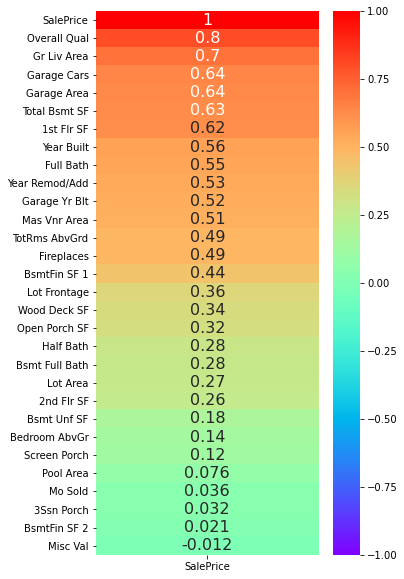

In [26]:
top_features = train.corr()[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(30)
plt.figure(figsize=(5,10))
sns.heatmap(top_features,cmap='rainbow',annot=True,annot_kws={"size": 16},vmin=-1)

In [27]:
#Step3:Exploratory Data Analysis(EDA) & Outliers Detection.
def plot_data(col, discrete=False):
    if discrete:
        fig, ax = plt.subplots(1,2,figsize=(14,6))
        sns.stripplot(x=col, y='SalePrice', data=train, ax=ax[0])
        sns.countplot(train[col], ax=ax[1])
        fig.suptitle(str(col) + ' Analysis')
    else:
        fig, ax = plt.subplots(1,2,figsize=(12,6))
        sns.scatterplot(x=col, y='SalePrice', data=train, ax=ax[0])
        sns.distplot(train[col], kde=False, ax=ax[1])
        fig.suptitle(str(col) + ' Analysis')

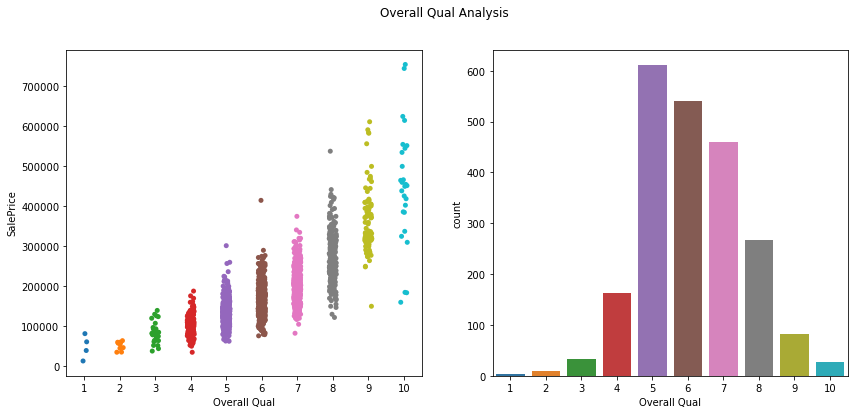

In [28]:
#Step3:Exploratory Data Analysis(EDA) & Outliers Detection.
plot_data('Overall Qual',True)
#We see there are two outliers with 10 overall quality and sale price less than 200000.

In [30]:
train = train.drop(train[(train['Overall Qual'] == 10) & (train['SalePrice'] < 200000)].index)

In [38]:

print(data[:0])

Empty DataFrame
Columns: [Order, PID, MS SubClass, Lot Frontage, Lot Area, Overall Qual, Overall Cond, Year Built, Year Remod/Add, Mas Vnr Area, BsmtFin SF 1, BsmtFin SF 2, Bsmt Unf SF, Total Bsmt SF, 1st Flr SF, 2nd Flr SF, Low Qual Fin SF, Gr Liv Area, Bsmt Full Bath, Bsmt Half Bath, Full Bath, Half Bath, Bedroom AbvGr, Kitchen AbvGr, TotRms AbvGrd, Fireplaces, Garage Yr Blt, Garage Cars, Garage Area, Wood Deck SF, Open Porch SF, Enclosed Porch, 3Ssn Porch, Screen Porch, Pool Area, Misc Val, Mo Sold, Yr Sold, MS Zoning_A (agr), MS Zoning_C (all), MS Zoning_FV, MS Zoning_I (all), MS Zoning_RH, MS Zoning_RL, MS Zoning_RM, Street_Grvl, Street_Pave, Alley_Grvl, Alley_NA, Alley_Pave, Lot Shape_IR1, Lot Shape_IR2, Lot Shape_IR3, Lot Shape_Reg, Land Contour_Bnk, Land Contour_HLS, Land Contour_Low, Land Contour_Lvl, Utilities_AllPub, Utilities_NoSeWa, Utilities_NoSewr, Lot Config_Corner, Lot Config_CulDSac, Lot Config_FR2, Lot Config_FR3, Lot Config_Inside, Land Slope_Gtl, Land Slope_Mod, La

In [42]:
data['Total_Square_Feet'] = (data['BsmtFin SF 1'] + data['BsmtFin SF 2'] + data['1st Flr SF'] + data['2nd Flr SF'] + data['Total Bsmt SF'])

data['Total_Bath'] = (data['Full Bath'] + (0.5 * data['Half Bath']) + data['Bsmt Full Bath'] + (0.5 * data['Bsmt Half Bath']))

data['Total_Porch_Area'] = (data['Open Porch SF'] + data['3Ssn Porch'] + data['Enclosed Porch'] + data['Screen Porch'] + data['Wood Deck SF'])

data['SqFtPerRoom'] = data['Gr Liv Area'] / (data['TotRms AbvGrd'] + data['Full Bath'] + data['Half Bath'] + data['Kitchen AbvGr'])

ValueError: Could not interpret value `TotalBsmtSF` for parameter `x`

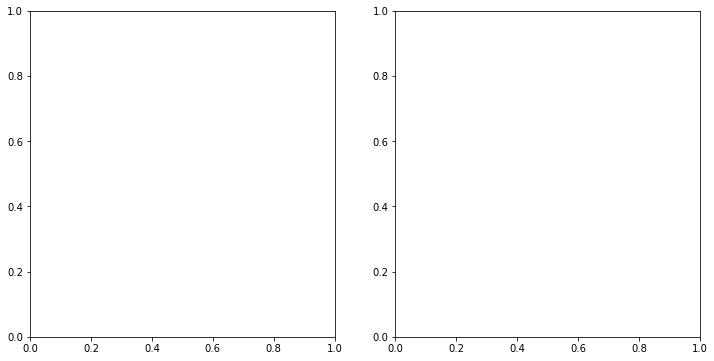

In [46]:
plot_data('TotalBsmtSF')

In [47]:
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

ValueError: could not convert string to float: 'RL'

In [48]:
X = train.copy()
X.drop(['SalePrice'],axis=1,inplace=True) # Dropped the y feature
y = train['SalePrice'].values

In [49]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('layers', 2, 10)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mse'])
    return model

In [54]:
tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=10,
    executions_per_trial=3,
    directory='model_dir',
    project_name='House_Price_Prediction')
 
tuner.search(X[1100:],y[1100:],batch_size=128,epochs=200,validation_data=validation_data=(X[:1100],y[:1100]))

SyntaxError: invalid syntax (<ipython-input-54-90a5ca3ebe31>, line 9)

In [ ]:
model = tuner.get_best_models(1)[0]

In [55]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(320, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(384, activation='relu'))
    model.add(Dense(352, activation='relu'))
    model.add(Dense(448, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'mse')
    return model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 320)               26240     
_________________________________________________________________
dense_1 (Dense)              (None, 384)               123264    
_________________________________________________________________
dense_2 (Dense)              (None, 352)               135520    
_________________________________________________________________
dense_3 (Dense)              (None, 448)               158144    
_________________________________________________________________
dense_4 (Dense)              (None, 160)               71840     
_________________________________________________________________
dense_5 (Dense)              (None, 160)               25760     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                5

In [56]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(x=X,y=y,
          validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[early_stop])
losses = pd.DataFrame(model.history.history)
losses.plot()

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).